<a href="https://colab.research.google.com/github/AnsimovDaniel/DeepLearningProject/blob/main/CV_mnist_net_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Digits Classification using Neural Networks



Mount your drive in order to run locally with colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


download & load the MNIST dataset.

*just run the next two cells and observe the outputs (shift&enter)

the training data set contains 60000 samples
each sample image from the training data set is a column-stacked grayscale image of 784 pixels
 this vectorized arrangement of the data is suitable for a Fully-Connected NN (as apposed to a Convolutional NN)
these column-stacked images can be reshaped to an image of (28, 28) pixels


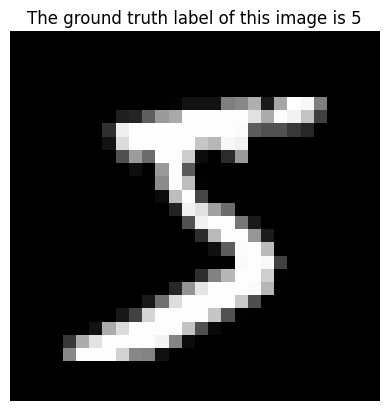

In [ ]:

#importing modules that will be in use
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import gzip
import pickle
from PIL import Image
import random
import numpy as np

def _download(file_name):
    file_path = os.path.join(dataset_dir,file_name)

    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_name)
    print("Done")

def download_mnist():
    for v in key_file.values():
       _download(v)

def _load_label(file_name):
    file_path =  os.path.join(dataset_dir, file_name)

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")

    return labels

def _load_img(file_name):
    file_path = os.path.join(dataset_dir,file_name)

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")

    return data

def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])

    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1

    return T

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """
    Parameters
    ----------
    normalize : Normalize the pixel values
    flatten : Flatten the images as one array
    one_hot_label : Encode the labels as a one-hot array

    Returns
    -------
    (Trainig Image, Training Label), (Test Image, Test Label)
    """
    if not os.path.exists(save_file):
        init_mnist()

    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)

    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0

    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])


# Load the MNIST dataset
url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = '/content'
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=True)


# printing data shape

print('the training data set contains '+ str(x_train.shape[0]) + ' samples')

img = x_train[0]
label = t_train[0]

img = img.reshape(28, 28)
print('each sample image from the training data set is a column-stacked grayscale image of '+ str(x_train.shape[1]) +' pixels'
      + '\n this vectorized arrangement of the data is suitable for a Fully-Connected NN (as apposed to a Convolutional NN)' )
print('these column-stacked images can be reshaped to an image of ' +str(img.shape)+ ' pixels')

# printing a sample from the dataset

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('The ground truth label of this image is '+str(label))
plt.show()

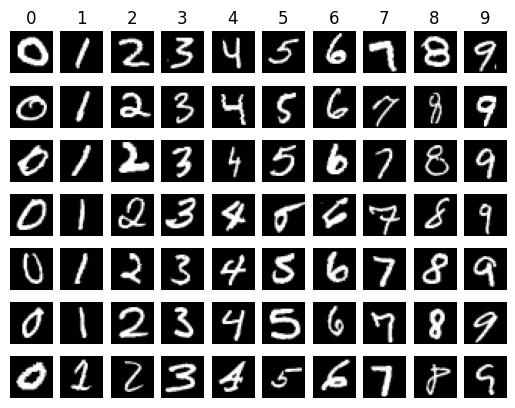

In [ ]:
# Visualize some examples from the dataset.
# We'll show a few examples of training images from each class.
num_classes = 10
samples_per_class = 7
for cls in range(num_classes):
    idxs = np.argwhere(t_train==cls)
    sample = np.random.choice(idxs.shape[0], samples_per_class, replace=False) # randomly picks 7 from the appearences
    idxs=idxs[sample]

    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + cls + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        img = x_train[idx].reshape(28, 28)

        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

**QUESTION 1**:What are vanishing gradients? Name one known activation function that has this problem and one that does not.

**ANSWER**: the heart of NN train, is calculating the gradient and going in direction of negative gradient to achieve minimum. however, if the gradient is close to zero, each step became very small, and the learning - frustrating.
We see it in sigmoid function, that has thisproblem, that we use in our network. why it don't cause a problem? maybe because our network not deep enough.
What activation function doesn' have it? Leaky RELU. it has gradient of 1 for positive values, some small gradient for negative values, and the needed nonlinearity achieved by the fact that function non-linear at zero.








here we will implement the sigmoid activation function and it's gradient

In [ ]:

def sigmoid(x):
    clipped_x = np.clip(x, -500, 500)
    sig = 1 / (1 + np.exp(-clipped_x))
    return sig
def sigmoid_grad(x):
    sig = sigmoid(x)
    sig_grad = sig * (1 - sig)
    return sig_grad


Implement a fully-vectorized loss function for the Softmax classifier
Make sure the softmax is stable.
To make our softmax function numerically stable,we simply normalize the values in the vector,
by multiplying the numerator and denominator with a constant C.
We can choose an arbitrary value for log(C) term, but generally log(C)=−max(a) is chosen, as it shifts all of elements in the vector to negative to zero, and negatives with large exponents saturate to zero rather than the infinity.

In [ ]:
def softmax(x):
    """
  Softmax loss function, should be implemented in a vectorized fashion (without loops)


  Inputs:
  - X: A numpy array of shape (N, C) containing a minibatch of data.
  Returns:
  - probabilities: A numpy array of shape (N, C) containing the softmax probabilities.

  if you are not careful here, it is easy to run into numeric instability
     """
    shifted_x = x - np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(shifted_x)
    probabilities = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    return probabilities

def cross_entropy_error(y, t):
    """
    Inputs:

    - t:  A numpy array of shape (N,C) containing  a minibatch of training labels, it is a one-hot array,
      with t[GT]=1 and t=0 elsewhere, where GT is the ground truth label ;
    - y: A numpy array of shape (N, C) containing the softmax probabilities (the NN's output).

    Returns a tuple of:
    - loss as single float (do not forget to divide by the number of samples in the minibatch (N))
    """
    epsilon = 1e-15
    y = np.clip(y, epsilon, 1 - epsilon)

    error = -np.sum(t * np.log(y)) / len(y)
    return error

We will design and train a two-layer fully-connected neural network with sigmoid nonlinearity and
softmax cross entropy loss. We assume an input dimension of D=784, a hidden dimension of H, and perform classification over C classes.

The architecture should be fullyconnected -> sigmoid -> fullyconnected -> softmax.

The learnable parameters of the model are stored in the dictionary,
'params', that maps parameter names to numpy arrays.

In the next cell we will initialize the weights and biases, design the fully connected(fc) forward and backward functions that will be in use for the training (using SGD).



In [ ]:
def TwoLayerNet( input_size, hidden_size, output_size, weight_init_std=0.01):
    ############################################################################
    # TODO: Initialize the weights and biases of the two-layer net. Weights    #
    # should be initialized from a Gaussian with standard deviation equal to   #
    # weight_init_std, and biases should be initialized to zero. All weights and  #
    # biases should be stored in the dictionary 'params', with first layer  #
    # weights and biases using the keys 'W1' and 'b1' and second layer weights #
    # and biases using the keys 'W2' and 'b2'.                                 #
    ############################################################################
    params = {}

    params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    params['b1'] = np.zeros((1, hidden_size))
    params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    params['b2'] = np.zeros((1, output_size))

    return params


def FC_forward(x, w, b):
    """
    Computes the forward pass for a fully-connected layer.
    The input x has shape (N, D) and contains a minibatch of N
    examples, where each example x[i] has shape D and will be transformed to an output vector of dimension M.
    Inputs:
    - x: A numpy array containing input data, of shape (N, D)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output result of the forward pass, of shape (N, M)
    - cache: (x, w, b)
    """

    out = np.dot(x, w) + b
    cache = (x, w, b)
    return out, cache



def FC_backward(dout, cache):
    """
    Computes the backward pass for a fully-connected layer.
    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
    - w: Weights, of shape (D, M)
    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, D)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None

    dx = np.dot(dout, w.T)
    dw = np.dot(x.T, dout)
    db = np.sum(dout, axis=0)
    return dx, dw, db



Here we will design the entire model, which outputs the NN's probabilities and gradients.


In [ ]:
def Model(params, x, t):
    """
    Computes the backward pass for a fully-connected layer.
    Inputs:
    - params:  dictionary with first layer weights and biases using the keys 'W1' and 'b1' and second layer weights
    and biases using the keys 'W2' and 'b2'. each with dimensions corresponding its input and output dimensions.
    - x: Input data, of shape (N,D)
    - t:  A numpy array of shape (N,C) containing training labels, it is a one-hot array,
      with t[GT]=1 and t=0 elsewhere, where GT is the ground truth label ;
    Returns:
    - y: the output probabilities for the minibatch (at the end of the forward pass) of shape (N,C)
    - grads: dictionary containing gradients of the loss with respect to W1, W2, b1, b2.

    note: use the FC_forward ,FC_backward functions.

    """
    W1, W2 = params['W1'], params['W2']
    b1, b2 = params['b1'], params['b2']
    grads = {'W1': None ,'W2': None, 'b1': None ,'b2': None }

    batch_num = x.shape[0]

    #############################################################################
    #                             YOUR CODE                                     #
    #############################################################################
    # forward (fullyconnected -> sigmoid -> fullyconnected -> softmax).
    out1, cache1 = FC_forward(x, W1, b1)
    hidden_layer = sigmoid(out1)
    out2, cache2 = FC_forward(hidden_layer, W2, b2)
    y = softmax(out2)

    # backward - calculate gradients.

    dy = y - t
    dx2, dw2, db2 = FC_backward(dy, cache2)
    d_hidden = dx2 * (hidden_layer * (1 - hidden_layer))
    dx1, dw1, db1 = FC_backward(d_hidden, cache1)

    grads['W1'], grads['b1'] = dw1, db1
    grads['W2'], grads['b2'] = dw2, db2

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return grads, y

Compute the accuracy of the NNs predictions.


In [ ]:


def accuracy(y,t):
    """
    Computes the accuracy of the NN's predictions.
    Inputs:
    - t:  A numpy array of shape (N,C) containing training labels, it is a one-hot array,
      with t[GT]=1 and t=0 elsewhere, where GT is the ground truth label ;
    - y: the output probabilities for the minibatch (at the end of the forward pass) of shape (N,C)
    Returns:
    - accuracy: a single float of the average accuracy.
    """
    #############################################################################
    #                             YOUR CODE                                     #
    #############################################################################
    predicted_labels = np.argmax(y, axis=1)
    ground_truth_labels = np.argmax(t, axis=1)

    correct_predictions = np.sum(predicted_labels == ground_truth_labels)
    total_samples = y.shape[0]

    accuracy = correct_predictions / total_samples * 100

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return accuracy



Trianing the model:
To train our network we will use minibatch SGD.  
*Note that the test dataset is actually used as the validation dataset in the training

training of 100 epochs, each epoch will have 469 iterations
train acc: 79.28% |  test acc: 91.16% |  loss for epoch 0: 0.6545426877998385
train acc: 92.01% |  test acc: 93.04% |  loss for epoch 1: 0.27688845543392865
train acc: 93.54% |  test acc: 93.99% |  loss for epoch 2: 0.22195281405665426
train acc: 94.51% |  test acc: 94.99% |  loss for epoch 3: 0.18761215643739024
train acc: 95.47% |  test acc: 95.34% |  loss for epoch 4: 0.1576653174975286
train acc: 96.02% |  test acc: 95.66% |  loss for epoch 5: 0.13771078694672792
train acc: 96.48% |  test acc: 96.16% |  loss for epoch 6: 0.1207843785740986
train acc: 96.87% |  test acc: 96.35000000000001% |  loss for epoch 7: 0.10804065337403447
train acc: 97.20% |  test acc: 96.55% |  loss for epoch 8: 0.09901070534955758
train acc: 97.41% |  test acc: 96.77% |  loss for epoch 9: 0.09259926117553399
train acc: 97.63% |  test acc: 96.81% |  loss for epoch 10: 0.08304775073949572
train acc: 97.78% |  test acc: 97.08% |  loss for epoch 11: 0

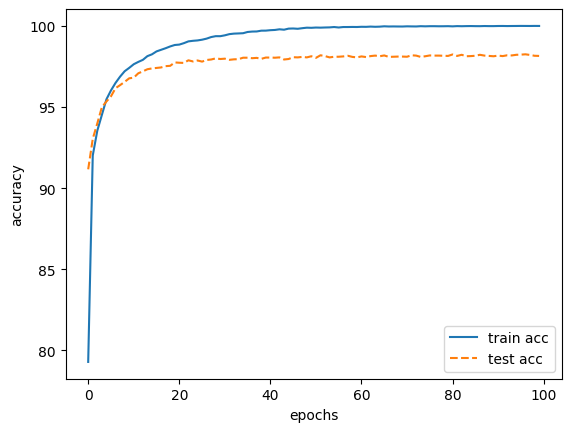

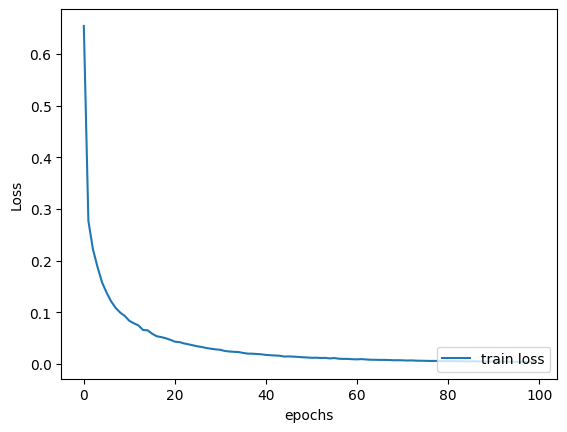

In [ ]:


# You should be able to receive at least 97% accuracy, choose hyperparameters accordingly.

epochs = 100
mini_batch_size = 128
learning_rate = 0.005
num_hidden_cells = 128

def Train(epochs_num, batch_size, lr, H):
    #  Dividing a dataset into training data and test data

    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
    C=10
    D=x_train.shape[1]
    network_params = TwoLayerNet(input_size=D, hidden_size=H, output_size=C) #hidden_size is the only hyperparameter here

    train_size = x_train.shape[0]
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []
    iter_per_epoch = round(train_size / batch_size)

    print('training of ' + str(epochs_num) +' epochs, each epoch will have '+ str(iter_per_epoch)+ ' iterations')
    for i in range(epochs_num):

        train_loss_iter= []
        train_acc_iter= []

        for k in range(iter_per_epoch):


            #############################################################################
            #                             YOUR CODE                                     #
            #############################################################################
            # 1. Select part of training data (mini-batch) randomly
            batch_mask = np.random.choice(train_size, batch_size)
            x_batch = x_train[batch_mask]
            t_batch = t_train[batch_mask]

            # 2. Calculate the predictions and the gradients to reduce the value of the loss function
            grads, y_batch = Model(network_params, x_batch, t_batch)

            # 3. Update weights and biases with the gradients
            for key in network_params.keys():
                network_params[key] -= lr * grads[key]

            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Calculate the loss and accuracy for visalizaton

            error=cross_entropy_error(y_batch, t_batch)
            train_loss_iter.append(error)
            acc_iter=accuracy(y_batch, t_batch)
            train_acc_iter.append(acc_iter)
            if k == iter_per_epoch-1:
                train_acc = np.mean(train_acc_iter)
                train_acc_list.append(train_acc)
                train_loss_list.append(np.mean(train_loss_iter))

                _, y_test = Model(network_params, x_test, t_test)
                test_acc = accuracy(y_test, t_test)
                test_acc_list.append(test_acc)
                print("train acc: " + str(train_acc)[:5] + "% |  test acc: "   + str(test_acc) + "% |  loss for epoch " + str(i) +": "+ str(np.mean(train_loss_iter)))
    return train_acc_list, test_acc_list, train_loss_list, network_params

train_acc, test_acc, train_loss, net_params = Train(epochs, mini_batch_size, learning_rate, num_hidden_cells)

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc))
plt.plot(x, train_acc, label='train acc')
plt.plot(x, test_acc, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc='lower right')
plt.show()


markers = {'train': 'o'}
x = np.arange(len(train_loss))
plt.plot(x, train_loss, label='train loss')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(loc='lower right')
plt.show()


# You should be able to receive at least 97% accuracy, choose hyperparameters accordingly.


**QUESTION 2:** Explain the results looking at the visualizations above, base your answer on the hyperparameters.

**ANSWER:**
1: epochs = 100, mini_batch_size = 512, learning_rate = 0.005, num_hidden_cells = 256, train acc: 99.95% |  test acc: 97.44%

2: epochs = 100, mini_batch_size = 512, learning_rate = 0.005, num_hidden_cells = 512, train acc: 98.91% |  test acc: 96.26%

3: epochs = 100, mini_batch_size = 512, learning_rate = 0.01, num_hidden_cells = 256, train acc: 97.71% |  test acc: 94.7 The accuracy ossilates a bit in the end.

4: epochs = 100, mini_batch_size = 256, learning_rate = 0.005, num_hidden_cells = 256, train acc: 99.99% |  test acc: 98.04%

5: epochs = 100, mini_batch_size = 256, learning_rate = 0.005, num_hidden_cells = 512, train acc: 99.99% |  test acc: 97.92%

6: epochs = 100, mini_batch_size = 256, learning_rate = 0.005, num_hidden_cells = 128, train acc: 100.0% |  test acc: 97.96%

7: epochs = 100, mini_batch_size = 256, learning_rate = 0.0025, num_hidden_cells = 128, train acc: 99.87% |  test acc: 97.92999999999999%

8: epochs = 100, mini_batch_size = 128, learning_rate = 0.005, num_hidden_cells = 128, train acc: 100.0% |  test acc: 98.3%

Several conclusions

- increase of hidden parameters number (neurons) do not result in perfermance increase, even more, the accuracy degrades, I guess it happen because theencodedinformation became too sparse.
- learning rate - increase of learning rate lead to accuracy osscilating, the learning step has morechances to pass over the minima. Too low learning rate can lead not achieving the minima.
- epochs - it telling us how many time we pass over the data set for train. if we not in overfitting mode, which we didn't saw here, invrease of epochs number will not suppose to lead to performance degradation.
- mini_batch_size - surprisingly batch size decrease leaded toperformance increase, i guess  it happen  because each batch averaged during the study. the drawback is of course calculation increase time.

**QUESTION** 3: Suggest a way to improve the results by changing the networks's architecture  

**ANSWER**: we saw that increase of neuron amount will not lead to performance increase. The  change that we suggest, is  arranging the neurons in several layers, this way, maybe more subtle connections between pixels will be learned. However, the error that we saw is not too large, and therefore it will be maybe hard to see significant improvement.




(784, 128)


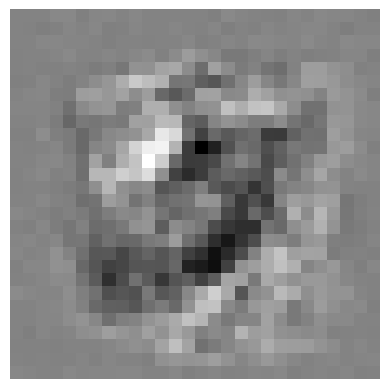

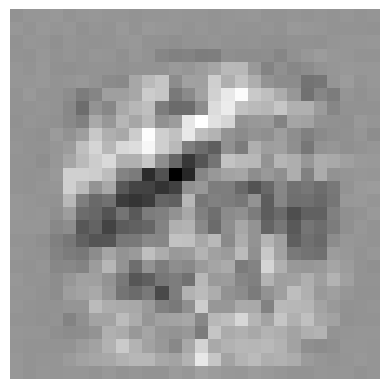

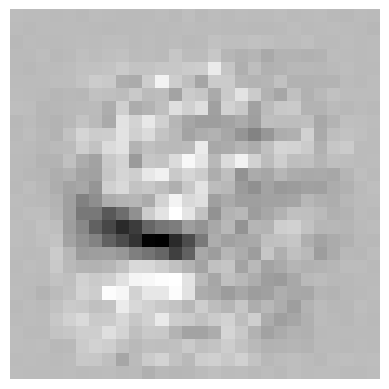

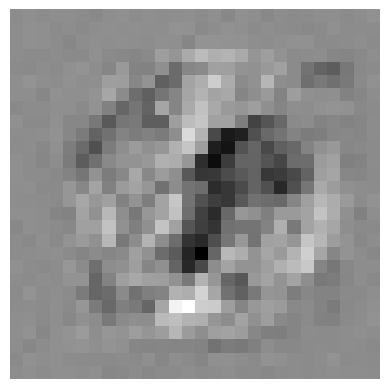

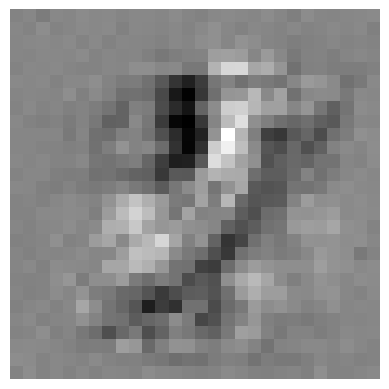

In [ ]:
# Visualize some weights. features of digits should be somehow present.
def show_net_weights(params):
    W1 = params['W1']
    print(W1.shape)
    for i in range(5):
        W = W1[:,i*5].reshape(28, 28)
        plt.imshow(W,cmap='gray')
        plt.axis('off')
        plt.show()

show_net_weights(net_params)


In [ ]:
t_train.shape
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

Implement, train and test the same two-layer network, using a **deep learning library** (pytorch/tensorflow/keras).

As before, you should be able to receive at least 97% accuracy.

Please note, that in this section you will need to implement the model, the training and the testing by yourself (you may use the code in earlier sections)
Don't forget to print the accuracy during training (in the same format as before).

For installing a deep learning library, you should use "!pip3 install..." (lookup the compatible syntex for your library)

In [ ]:
from keras.initializers import Initializer

class CustomWeightInitializer(Initializer):
    def __init__(self, weight_init_std):
        self.weight_init_std = weight_init_std

    def __call__(self, shape, dtype=None):
        return self.weight_init_std * np.random.randn(*shape)

weight_init_std = 0.01
input_size = 784
hidden_size = 128

custom_initializer = CustomWeightInitializer(weight_init_std)


In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='sigmoid', input_shape=(784,), kernel_initializer=custom_initializer),
    tf.keras.layers.Dense(10, activation = 'softmax',  kernel_initializer=custom_initializer)
])

model.compile(optimizer=tf.keras.optimizers.SGD(0.585),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
t_train.shape

(60000, 10)

In [ ]:
history = model.fit(x_train, t_train, 128, epochs=100, validation_data=(x_test, t_test))

Epoch 1/100
469/469 [==============================] - 3s 5ms/step - loss: 0.6905 - accuracy: 0.7832 - val_loss: 0.3131 - val_accuracy: 0.9103
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2877 - accuracy: 0.9167 - val_loss: 0.2537 - val_accuracy: 0.9249
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2360 - accuracy: 0.9316 - val_loss: 0.2206 - val_accuracy: 0.9347
Epoch 4/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1996 - accuracy: 0.9426 - val_loss: 0.1956 - val_accuracy: 0.9408
Epoch 5/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1738 - accuracy: 0.9504 - val_loss: 0.1639 - val_accuracy: 0.9534
Epoch 6/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1533 - accuracy: 0.9564 - val_loss: 0.1515 - val_accuracy: 0.9553
Epoch 7/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1366 - accuracy: 0.9612 - val_loss: 0.1367 - val_accuracy: 0.9594

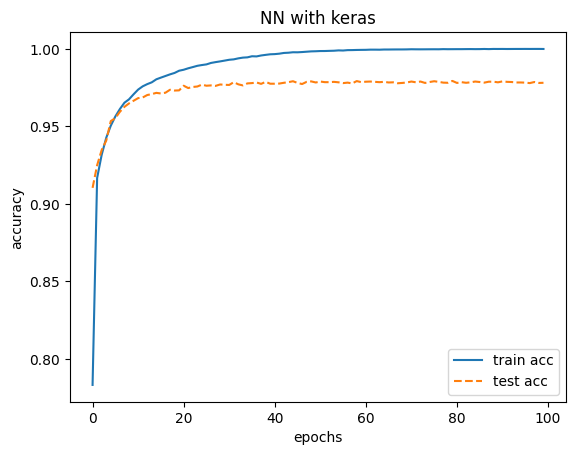

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('NN with keras')
plt.legend(loc='lower right')
plt.show()

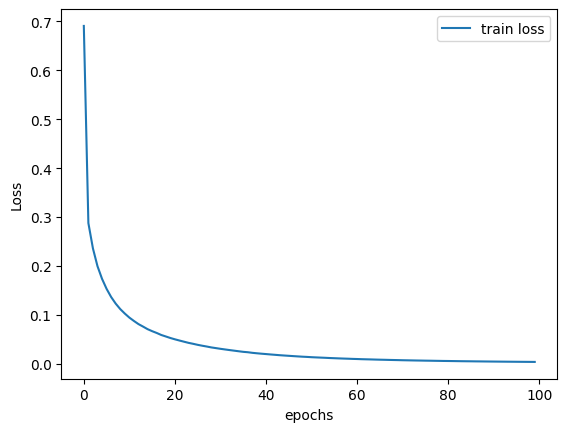

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.show()
